In [44]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import  DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, plot_confusion_matrix
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
df =  pd.read_csv('autism_dataset/data.csv', index_col='Case_No')

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1054 entries, 1 to 1054
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   A1                      1054 non-null   int64 
 1   A2                      1054 non-null   int64 
 2   A3                      1054 non-null   int64 
 3   A4                      1054 non-null   int64 
 4   A5                      1054 non-null   int64 
 5   A6                      1054 non-null   int64 
 6   A7                      1054 non-null   int64 
 7   A8                      1054 non-null   int64 
 8   A9                      1054 non-null   int64 
 9   A10                     1054 non-null   int64 
 10  Age_Mons                1054 non-null   int64 
 11  Sex                     1054 non-null   object
 12  Ethnicity               1054 non-null   object
 13  Jaundice                1054 non-null   object
 14  Family_mem_with_ASD     1054 non-null   object
 15  Who 

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,Age_Mons,Sex,Ethnicity,Jaundice,Family_mem_with_ASD,Who completed the test,Class/ASD Traits
Case_No,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,1,1,0,1,28,f,middle eastern,yes,no,family member,No
2,1,1,0,0,0,1,1,0,0,0,36,m,White European,yes,no,family member,Yes
3,1,0,0,0,0,0,1,1,0,1,36,m,middle eastern,yes,no,family member,Yes
4,1,1,1,1,1,1,1,1,1,1,24,m,Hispanic,no,no,family member,Yes
5,1,1,0,1,1,1,1,1,1,1,20,f,White European,no,yes,family member,Yes


Printing possible pool of values for each column of the dataframe.

In [3]:
for column in df.columns:
    unique_values = df[column].unique()
    print(f"'{column}' : {sorted(unique_values.tolist())}")

'A1' : [0, 1]
'A2' : [0, 1]
'A3' : [0, 1]
'A4' : [0, 1]
'A5' : [0, 1]
'A6' : [0, 1]
'A7' : [0, 1]
'A8' : [0, 1]
'A9' : [0, 1]
'A10' : [0, 1]
'Age_Mons' : [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]
'Sex' : ['f', 'm']
'Ethnicity' : ['Hispanic', 'Latino', 'Native Indian', 'Others', 'Pacifica', 'White European', 'asian', 'black', 'middle eastern', 'mixed', 'south asian']
'Jaundice' : ['no', 'yes']
'Family_mem_with_ASD' : ['no', 'yes']
'Who completed the test' : ['Health Care Professional', 'Health care professional', 'Others', 'Self', 'family member']
'Class/ASD Traits ' : ['No', 'Yes']


Checking the proportion of observations that were completed by the individual without help from others.

In [4]:
total_entries = len(df)
selected_entries = len(df[df['Who completed the test'] == 'Self'])
percentage = (selected_entries / total_entries) * 100

print(f"Percentage of entries where test is self-completed: {percentage:.2f}% which is {total_entries*percentage/100} entries")

Percentage of entries where test is self-completed: 0.38% which is 4.0 entries


The child at this age most probably can't perform the test on its own so the entries which have self label are most probably false. As the percentage of such entries is very low, let's remove them from the dataframe.

In [5]:
df = df[df['Who completed the test'] != 'Self']
len(df)

1050

Cleaning the data

In [6]:
# fixing the naming of the columns
df.columns = df.columns.str.strip()
df_cleaned = df.rename(columns= {'Age_Mons':'Age', 'Family_mem_with_ASD': 'HasFamilyAsd', 'Who completed the test': 'CompletedBy', 'Class/ASD Traits':'HasAsdTraits'})

#fixing the values inside the columns
df_cleaned['CompletedBy'] = df_cleaned['CompletedBy'].str.title().str.replace(' ', '')
df_cleaned['Ethnicity'] = df_cleaned['Ethnicity'].str.title().str.replace(' ', '')

for column in df_cleaned.columns:
    unique_values = df_cleaned[column].unique()
    print(f"'{column}' : {sorted(unique_values.tolist())}")

'A1' : [0, 1]
'A2' : [0, 1]
'A3' : [0, 1]
'A4' : [0, 1]
'A5' : [0, 1]
'A6' : [0, 1]
'A7' : [0, 1]
'A8' : [0, 1]
'A9' : [0, 1]
'A10' : [0, 1]
'Age' : [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]
'Sex' : ['f', 'm']
'Ethnicity' : ['Asian', 'Black', 'Hispanic', 'Latino', 'MiddleEastern', 'Mixed', 'NativeIndian', 'Others', 'Pacifica', 'SouthAsian', 'WhiteEuropean']
'Jaundice' : ['no', 'yes']
'HasFamilyAsd' : ['no', 'yes']
'CompletedBy' : ['FamilyMember', 'HealthCareProfessional', 'Others']
'HasAsdTraits' : ['No', 'Yes']


Perform encoding of the categorical data.

In [7]:
# encoding of binary variables
df_cleaned['Sex'] = df_cleaned['Sex'].map({'f':0,'m':1}).astype(int)
df_cleaned['Jaundice'] = df_cleaned['Jaundice'].map({'no':0,'yes':1}).astype(int)
df_cleaned['HasFamilyAsd'] = df_cleaned['HasFamilyAsd'].map({'no':0,'yes':1}).astype(int)
df_cleaned['HasAsdTraits'] = df_cleaned['HasAsdTraits'].map({'No':0,'Yes':1}).astype(int)


#encoding of non binary variables
df_cleaned = pd.get_dummies(df_cleaned, columns=['CompletedBy'], prefix='CompletedBy')
df_cleaned = pd.get_dummies(df_cleaned, columns=['Ethnicity'], prefix='Ethnicity')

df_cleaned

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,...,Ethnicity_Black,Ethnicity_Hispanic,Ethnicity_Latino,Ethnicity_MiddleEastern,Ethnicity_Mixed,Ethnicity_NativeIndian,Ethnicity_Others,Ethnicity_Pacifica,Ethnicity_SouthAsian,Ethnicity_WhiteEuropean
Case_No,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,1,1,0,1,...,0,0,0,1,0,0,0,0,0,0
2,1,1,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,1,0,0,0,0,0,1,1,0,1,...,0,0,0,1,0,0,0,0,0,0
4,1,1,1,1,1,1,1,1,1,1,...,0,1,0,0,0,0,0,0,0,0
5,1,1,0,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1050,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1051,0,0,1,1,1,0,1,0,1,0,...,1,0,0,0,0,0,0,0,0,0
1052,1,0,1,1,1,1,1,1,1,1,...,0,0,0,1,0,0,0,0,0,0


Visualization of observation outcomes

<AxesSubplot:xlabel='Class/ASD Traits', ylabel='count'>

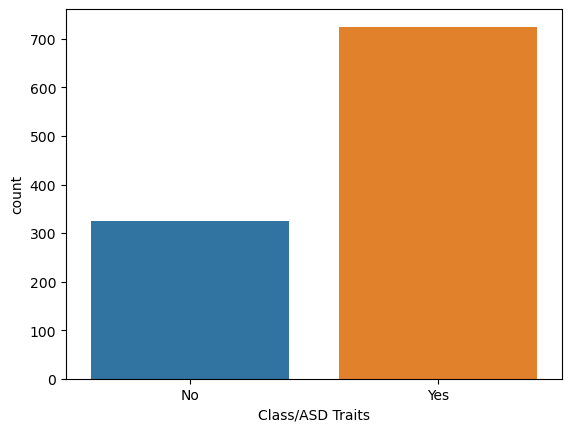

In [8]:
sns.countplot(x='Class/ASD Traits', data= df)

Splitting the data into training and testing sets.

In [9]:
X = df_cleaned.drop(columns='HasAsdTraits')
y = df_cleaned['HasAsdTraits']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [34]:
clasifier = KNeighborsClassifier()
parameters = {'n_neighbors': range(1, 11)}
gridsearch = GridSearchCV(clasifier, parameters, cv=9)
gridsearch.fit(X_train, y_train)
print("Best parametrs - ", gridsearch.best_estimator_)

Best parametrs -  KNeighborsClassifier(n_neighbors=9)


In [25]:
from sklearn.model_selection import cross_val_score
import numpy as np

k_values = list(range(1, 11))
accuracy_scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X, y, cv=5)
    accuracy_scores.append(np.mean(scores))

best_k = k_values[np.argmax(accuracy_scores)]

print(f"\nBest k value: {best_k}")


Best k value: 9


In [35]:
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train, y_train)
print("Accuracy of K-NN classifier on training data: ",
round(knn.score(X_train, y_train), 5))
print("Accuracy of K-NN classifier on test data: ",
round(knn.score(X_test, y_test), 5))

Accuracy of K-NN classifier on training data:  0.95476
Accuracy of K-NN classifier on test data:  0.94286


In [38]:
y_test_pred = knn.predict(X_test)
print("Classification Report - Test Data:")
test_report = classification_report(y_test, y_test_pred)
print(test_report)

Classification Report - Test Data:
              precision    recall  f1-score   support

           0       0.87      0.97      0.92        70
           1       0.98      0.93      0.96       140

    accuracy                           0.94       210
   macro avg       0.93      0.95      0.94       210
weighted avg       0.95      0.94      0.94       210



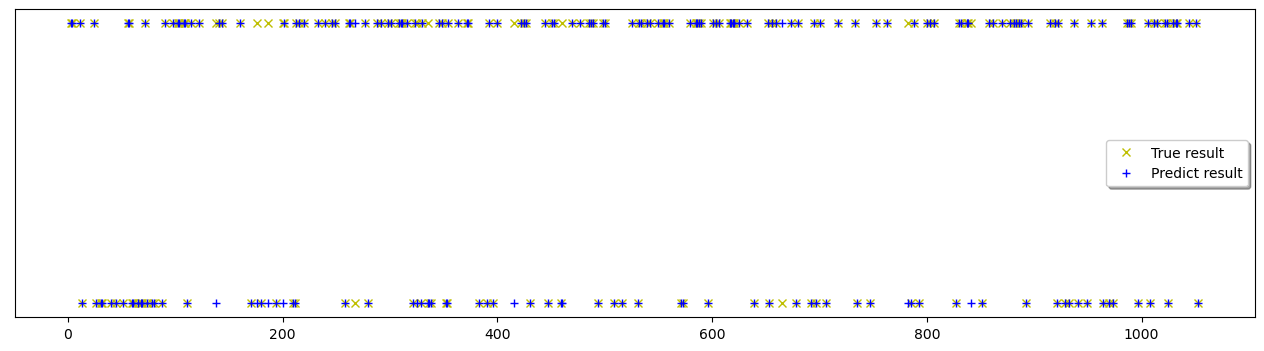

In [43]:
plt.rcParams["figure.figsize"] = (16, 4)
plt.gca().axes.get_yaxis().set_visible(False)
plt.plot(X_test.index, y_test, "yx", label="True result")
plt.plot(X_test.index, knn.predict(X_test), "b+", label="Predict result")
plt.legend(loc="center right", shadow=True)
plt.show()

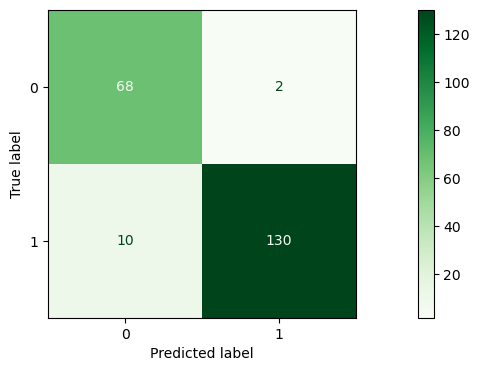

In [45]:
plot_confusion_matrix(knn, X_test, y_test, cmap="Greens")
plt.grid(False)

In [11]:
dtc = DecisionTreeClassifier(random_state=42)
dtc.fit(X_train, y_train)
print("Accuracy of DT classifier on training data: ",
round(dtc.score(X_train, y_train), 5))
print("Accuracy of DT classifier on test data: ",
round(dtc.score(X_test, y_test), 5))

Accuracy of DT classifier on training data:  1.0
Accuracy of DT classifier on test data:  0.91905


In [39]:
y_test_pred = dtc.predict(X_test)
print("Classification Report - Test Data:")
test_report = classification_report(y_test, y_test_pred)
print(test_report)

Classification Report - Test Data:
              precision    recall  f1-score   support

           0       0.88      0.87      0.88        70
           1       0.94      0.94      0.94       140

    accuracy                           0.92       210
   macro avg       0.91      0.91      0.91       210
weighted avg       0.92      0.92      0.92       210



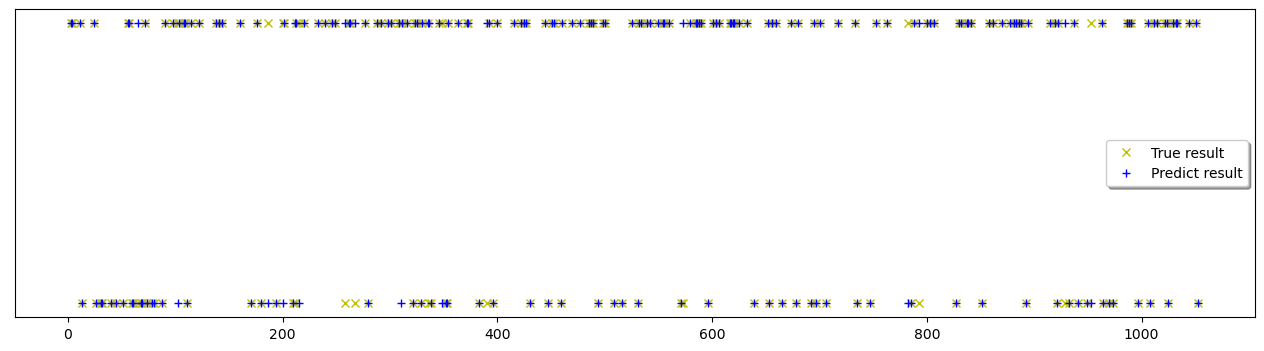

In [47]:
plt.rcParams["figure.figsize"] = (16, 4)
plt.gca().axes.get_yaxis().set_visible(False)
plt.plot(X_test.index, y_test, "yx", label="True result")
plt.plot(X_test.index, dtc.predict(X_test), "b+", label="Predict result")
plt.legend(loc="center right", shadow=True)
plt.show()

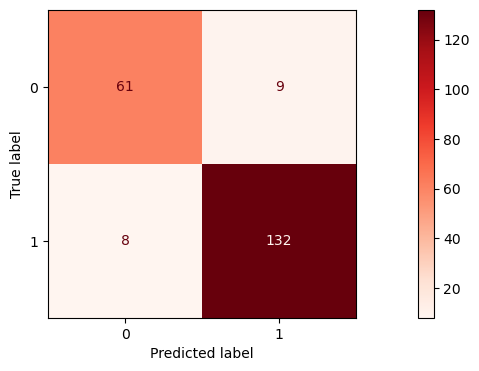

In [49]:
plot_confusion_matrix(dtc, X_test, y_test, cmap="Reds")
plt.grid(False)